# Kannada MNIST CNN

Kannada is a language spoken predominantly by people of Karnataka in southwestern India. The language has roughly 45 million native speakers and is written using the Kannada script.

The goal of this competition is to use Machine Learning to correctly label hand-written digits written in the Kannada script. The Kannada dataset format is based on the dataset used in the original MNIST dataset where the objective was the same but the hand-written digits were in Arabic numerals.

### If you find this code helpful please <span style="color:red">upvote</span>

## Initial Setup

Load the most widely used libraries numpy and pandas and check what input files are available to the notebook.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

input/test.csv
input/Dig-MNIST.csv
input/train.csv
input/sample_submission.csv


## Load Libraries

Load other useful libraries particularly the ones that we need to build the Convolutional Neural Network (CNN). This is an effective type of model for dealing with image recognition. In this competition access to the internet is not permitted for the kernel. We will exhibit building a model from scratch rather than using a pre-trained model.

In [2]:
import datetime
from keras.models import Sequential
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from keras import regularizers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.layers.convolutional import MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

## Load Data

Firstly let's read the data that the models will be working on.

In [3]:
print(('Start: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now())))
print(('Data Load and Preprocessing: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now())))
X_train = pd.read_csv("input/train.csv")
X_test = pd.read_csv("input/test.csv")
X_holdout = pd.read_csv("input/Dig-MNIST.csv")

Start: 2020-10-29 17:15:40
Data Load and Preprocessing: 2020-10-29 17:15:40


### Data Prep
A few preprocessing steps to get the data ready for our Machine Learning model. (Note X_test has a column called 'id' which X_train and X_holdout do not have)

In [4]:
id_train = X_train.index.values
y_train = X_train['label']
y_valid_pred = 0*y_train

X_train.drop(labels=['label'], axis=1, inplace=True)

# prepare the test data set by removing the id
X_test.drop(labels=['id'], axis=1, inplace=True) #remove the column that is not in the X_train and X_holdout

#prepare test data
X_test = X_test.astype('float32') / 255.
X_test = X_test.values.reshape(X_test.shape[0], 28, 28, 1).astype('float32')

# prepare the holdout data set
y_holdout = X_holdout['label']
X_holdout.drop(labels=['label'], axis=1, inplace=True)

#prepare holdout data
X_holdout = X_holdout.astype('float32') / 255.
X_holdout = X_holdout.values.reshape(X_holdout.shape[0], 28, 28, 1).astype('float32')


my_init = 'glorot_uniform'
my_activ = 'relu'
my_optimiser = 'adam'
my_epsilon = 1e-8
nb_classes = 10

## Data Visualisation

Below is a representation of what the Kannada digits look like to us. We can see that they have been captured with low resolution images.

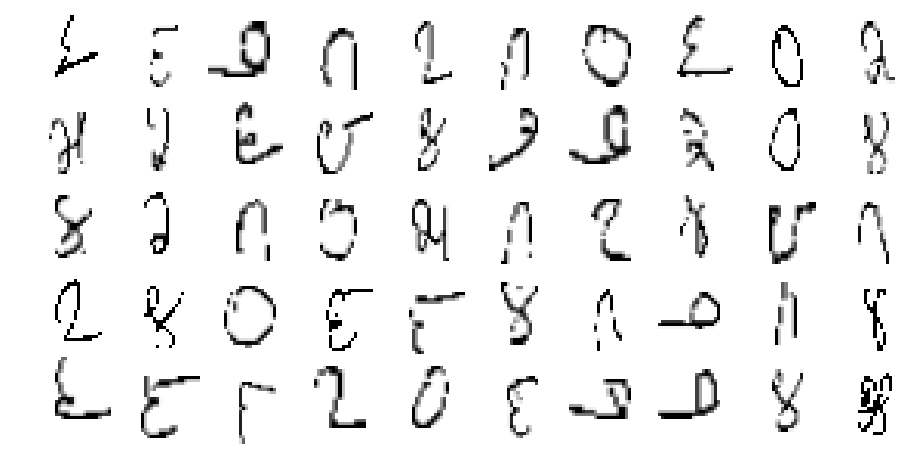

In [5]:
fig,ax=plt.subplots(5,10)
for i in range(5):
    for j in range(10):
        ax[i][j].imshow(X_test[np.random.randint(0,X_test.shape[0]),:,:,0],cmap=plt.cm.binary)
        ax[i][j].axis('off')
plt.subplots_adjust(wspace=0, hspace=0)        
fig.set_figwidth(16)
fig.set_figheight(8)
fig.show()

## Principal Component Analysis

Above we saw what the digits look like to humans. Here we see how ML models can go about learning to distinguish features. The PCA method seeks to obtain the optimal directions (or eigenvectors) that captures the most variance (spreads out the data points the most) whilst reducing the number of features. It may be informative (and cool) to visualise these directions and their associated eigenvalues. For the purposes of this notebook and for speed, I will invoke PCA to extract the top 30 eigenvalues from the digit dataset. So effectively we are reducing the original 28x28 image which is 784 features to just 30 features. We then visually compare the top eigenvalues i.e. those that explain the most variance, to some of the other smaller ones to see if we can glean any insights as follows:

In [6]:
# Invoke SKlearn's PCA method
n_components = 30
pca = PCA(n_components=n_components).fit(X_train.values)

eigenvalues = pca.components_.reshape(n_components, 28, 28)

# Extracting the PCA components ( eignevalues )
#eigenvalues = pca.components_.reshape(n_components, 28, 28)
eigenvalues = pca.components_

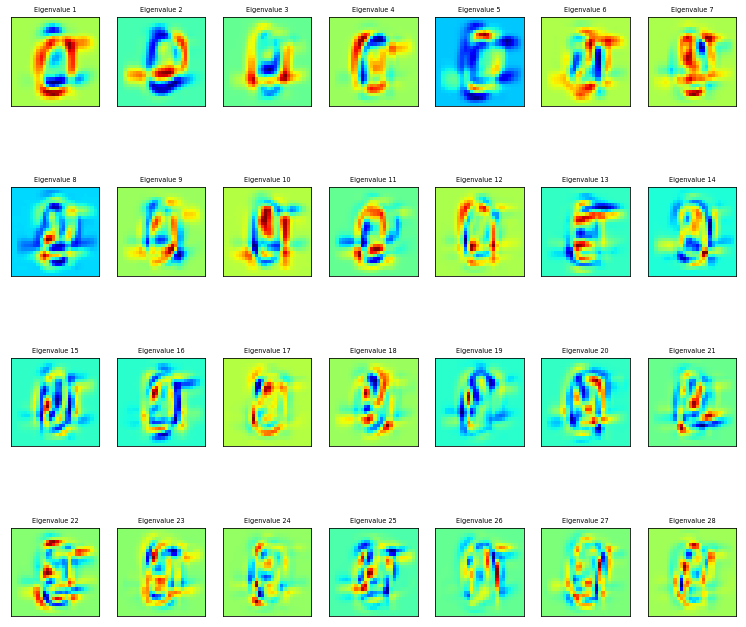

In [7]:
n_row = 4
n_col = 7

# Plot the first eignenvalues
plt.figure(figsize=(13,12))
for i in list(range(n_row * n_col)):
    offset =0
    plt.subplot(n_row, n_col, i + 1)
    plt.imshow(eigenvalues[i].reshape(28,28), cmap='jet')
    title_text = 'Eigenvalue ' + str(i + 1)
    plt.title(title_text, size=6.5)
    plt.xticks(())
    plt.yticks(())
plt.show()

#### What the plots show us

The subplots above portray the top 30 optimal directions or principal component axes that the PCA method has decided to generate for our digit dataset. Of interest is when one compares the first component "Eigenvalue 1" to the 28th component "Eigenvalue 28", it is obvious that more complicated directions or components are being generated in the search to maximise variance in the new feature subspace. For the CNN below we will use the full 784 features but the illustration above gives a visualisation about how ML models can learn features on an image.

### Model Function

Define a function that returns the model. This will set the model architecture and will prevent the need to type this all out repeatedly for the validation and prediction stages.

We will build a CNN of several layers. This is not a simple NN but it certainly isn't complex either relative to pretrained models that can contain over 100 layers.

The model uses a softmax output to output the probabilities for each of the 10 digits

In [8]:
def build_network(input_shape):    
    model = Sequential()
    # For an explanation on conv layers see http://cs231n.github.io/convolutional-networks/#conv
    # For an explanation on pooling layers see http://cs231n.github.io/convolutional-networks/#pool
    # By default the stride/subsample is 1 and there is no zero-padding.
    # use padding="same" if you want to preserve dimensions
    
    #model.add(ZeroPadding2D(padding=(2, 2), data_format="channels_last", input_shape=input_shape))
    model.add(Conv2D(filters=64, kernel_size=(5, 5), strides=(1, 1), input_shape=input_shape, padding="same", activation='relu', kernel_initializer=my_init))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))    
    model.add(Dropout(0.25))
    model.add(Conv2D(filters=128, kernel_size=(5, 5), strides=(1, 1), padding="same", activation='relu', kernel_initializer=my_init))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))    
    model.add(Dropout(0.25))
    model.add(Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding="same", activation='relu', kernel_initializer=my_init))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))    
    model.add(Dropout(0.25))
    
    # Flatten the 3D output to 1D tensor for a fully connected layer to accept the input
    model.add(Flatten())
    
    
    #Fully Connected Layer
    model.add(Dense(256, kernel_initializer=my_init))
    model.add(Activation(my_activ))
    model.add(BatchNormalization())
    model.add(Dropout(0.3)) #dropout is a type of regularisation. Regularisation helps to control overfitting
    #Fully Connected Layer
    model.add(Dense(128, kernel_initializer=my_init))
    model.add(Activation(my_activ))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    #Output layer
    model.add(Dense(nb_classes, activation='softmax')) 

    model.compile(optimizer=my_optimiser,
        loss='categorical_crossentropy',
        metrics=['accuracy'])
    

    return model

### Augmentation Settings

CNN's can often produce better results if they are fed not just the original input images. Here we take the input image data and make some specific types of adjustments. This process is called augmentation. For example if an image is rotated 1 degree to the right in many cases it will still be identifiable to a human as the same object. Similarly a model can be trained to still recognise the image. Again if we as humans zoom in slightly to the image often it is still recognisable. Once again a model can be trained to still be able to recognise the image. All these slight variations often allow the model to be trained in a more robust way. There are many other types of ways to adjust the image. Not all of them will be used here but there are some notes in the code below to briefly outline the types of augmentations that can be done.

In [9]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=12,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.25, # Randomly zoom image 
        shear_range=15, #move top of image along without moving the bottom or vice versa
        width_shift_range=0.25,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.25,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        data_format="channels_last" 
        )

### Charting Function

Later we will draw some charts. Here we set up the function we can call when we need to do that.

In [10]:
def PlotAcc(his, epoch):
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(1, epoch + 1), his.history["accuracy"], label="train_accuracy")
    plt.plot(np.arange(1, epoch + 1), his.history["val_accuracy"], label="val_accuracy")
    plt.title("Training and Validation Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Accuracy")
    plt.legend(loc="lower right")
    plt.show()

### Utility Function

Another function that we will use later.

In [11]:
def epoch_cv(df_cv_per_epoch_val_acc, fold_num):
    #Find the best epoch by the best single and the best moving average
    #Update the index to start at 1 with epoch 1 for the validation accuracy data
    if fold_num==0:
        df_cv_per_epoch_val_acc.index += 1 #needed so length of values matches length of index
    df_cv_per_epoch_val_acc['mean_val_acc'] = df_cv_per_epoch_val_acc.mean(axis=1)
    #Calculate an epoch moving average
    num_epochs = df_cv_per_epoch_val_acc.shape[0]
    
    for i in range(1, num_epochs+1):
        #print(i)
        if i<moving_average_period+1:
            df_cv_per_epoch_val_acc.at[i, 'moving_average'] = df_cv_per_epoch_val_acc.iloc[:i]['mean_val_acc'].mean()
        else:
            df_cv_per_epoch_val_acc.at[i, 'moving_average'] = df_cv_per_epoch_val_acc.iloc[i-moving_average_period:i]['mean_val_acc'].mean()
    
    #Locate the Best Epoch Number (not the value but the epoch number) by the Mean per epoch
    best_epoch_cv = df_cv_per_epoch_val_acc['mean_val_acc'].idxmax()
    #Locate the Best Epoch Number (not the value but the epoch number) by the Moving Average
    best_epoch_cv_by_moving_average = df_cv_per_epoch_val_acc['moving_average'].idxmax()
    
    return df_cv_per_epoch_val_acc, best_epoch_cv, best_epoch_cv_by_moving_average

#### Parameters

Here are some parameters that will be used to control what the notebook does later and what inputs are fed to the model and validation process.

In [12]:
Run_CV = "Y"
Run_Holdout_Validation = "Y"
Run_Kaggle_Pred = "Y"
n_epochs = 75 #333 #number of epochs
my_batch_size = 128
my_verbose = 0 #how much information keras shows per epoch 0 shows least, 1 shows moving arrows as each epoch progresses, 2 displays accuracy at the end of each epoch
K = 4 #number of folds
len_test = len(X_test)
moving_average_period = 10
mean_chart_lower_epoch_bound = 30

### Something to speed things up a little

The allowable run-time for models using a GPU in this competition is 2 hours. It is good practice to think about the compute time of models. One thing that can speed up the run-time of a model is to start with a higher learning rate and as the model increases its accuracy decrease the learning rate. If the learning rate is low all the time the model will be accurate but it will take a long time to train. If the learning rate is high all the time it will train quickly but will lose some accuracy. Decreasing the learning rate as the model progresses is one type of attempt to get good accuracy without long compute times.

In [13]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=4, verbose=my_verbose, factor=0.55, min_lr=0.00001)

### Execute
OK let's get going with our Machine Learning model!

In [14]:
print(" Epochs: " + str(n_epochs))
print(" Cross Validation Requested: " + Run_CV)
print(" Kaggle Prediction Requested: " + Run_Kaggle_Pred)

 Epochs: 75
 Cross Validation Requested: Y
 Kaggle Prediction Requested: Y


#### Cross-Validation

Validation is very important in Machine Learning. Cross-Validation tends to be more robust than a single train test split validation. However, cross-validation is also much more time consuming. In practice for neural networks, especially with large datasets, cross-validation may not be practical and it may be better to do validation on a single train test split of the data. This notebook is an example of cross-validation and also uses the Dig-MNIST data for holdout validation at the end.

 Batch Size: 128
 Number of K-Folds: 4
Fold Preparation: 2020-01-03 00:04:51
KFold Model Starting: 2020-01-03 00:04:51
Augmenting Data: 2020-01-03 00:04:54
Model Fitting: 2020-01-03 00:04:54
Fold: 0
 Fold Accuracy = 0.998133
Best Single Epoch: 35


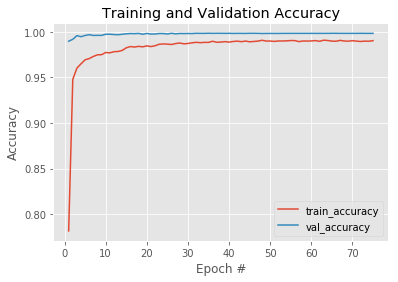

Augmenting Data: 2020-01-03 00:42:24
Model Fitting: 2020-01-03 00:42:24
Fold: 1
 Fold Accuracy = 0.997400
Best Single Epoch: 63


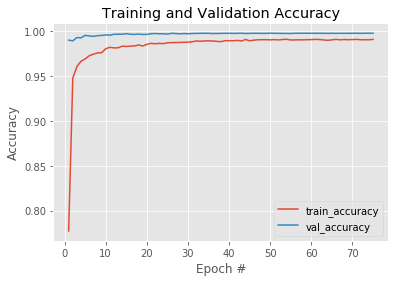

Augmenting Data: 2020-01-03 01:19:22
Model Fitting: 2020-01-03 01:19:22
Fold: 2
 Fold Accuracy = 0.997000
Best Single Epoch: 63


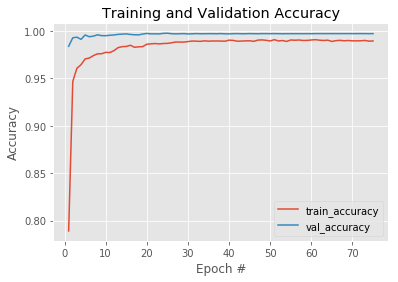

Augmenting Data: 2020-01-03 01:57:00
Model Fitting: 2020-01-03 01:57:00
Fold: 3
 Fold Accuracy = 0.997133
Best Single Epoch: 61


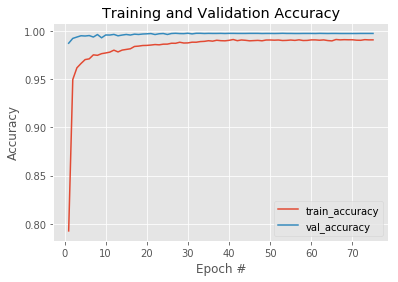

 Overall Out-of-Fold Accuracy = 0.9974
Writing Prediction: 2020-01-03 02:34:01


In [15]:
if Run_CV=="Y":
    print(" Batch Size: " + str(my_batch_size))
    print(" Number of K-Folds: " + str(K))


    print(('Fold Preparation: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now())))
    kfold = StratifiedKFold(n_splits = K, 
                            random_state = 2007, 
                            shuffle = True) 

    oof_pred = None
    df_cv_per_epoch_train_acc = pd.DataFrame()
    df_cv_per_epoch_val_acc = pd.DataFrame()
    
    print(('KFold Model Starting: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now())))
    
    for i, (f_ind, outf_ind) in enumerate(kfold.split(X_train, y_train)):
        my_optimiser = Adam(lr=0.004, beta_1=0.9, beta_2=0.999, epsilon=my_epsilon, decay=0.0, amsgrad=False)
        
        # Create data for this fold
        X_train_f, X_val_f = X_train.loc[f_ind].copy(), X_train.loc[outf_ind].copy()
    
        # Normalize and reshape
        X_train_f = X_train_f.astype('float32') / 255.
        X_train_f = X_train_f.values.reshape(X_train_f.shape[0], 28, 28, 1).astype('float32') #Fabien Tence suggests this shape suits Tensorflow but Theano requires 1, 28, 28
        X_val_f = X_val_f.astype('float32') / 255.
        X_val_f = X_val_f.values.reshape(X_val_f.shape[0], 28, 28, 1).astype('float32') #Fabien Tence suggests this shape suits Tensorflow but Theano requires 1, 28, 28

        #Identify the input_shape - the cnn needs this
        input_shape = X_train_f.shape[1:]
        nnet_model = build_network(input_shape)
     
        y_train_f, y_val_f = y_train[f_ind], y_train[outf_ind]
        y_train_f = y_train_f.values
        y_val_f = y_val_f.values
        y_val_f_series = y_val_f

        y_train_f = to_categorical(y_train_f, num_classes = nb_classes)
        y_val_f = to_categorical(y_val_f, num_classes = nb_classes)
    
        print(('Augmenting Data: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now())))    
        datagen.fit(X_train_f) #This step must be after reshaping
        # Run model for this fold
        print(('Model Fitting: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now())))
        print('Fold: ' + str(i))
        history = nnet_model.fit_generator(datagen.flow(X_train_f,y_train_f, batch_size=my_batch_size), epochs=n_epochs, verbose=my_verbose, 
                                           steps_per_epoch=X_train.shape[0] // my_batch_size, validation_data=(X_val_f,y_val_f), callbacks=[learning_rate_reduction])
                
        df_cv_per_epoch_train_acc['fold_'+str(i)] = history.history['accuracy']
        df_cv_per_epoch_val_acc['fold_'+str(i)] = history.history['val_accuracy']
        
        # Generate validation predictions for this fold
        y_preds = nnet_model.predict(X_val_f)
        if Run_Holdout_Validation=="Y":
            if i==0:
                holdout_preds = nnet_model.predict(X_holdout)
            else:
                holdout_preds = holdout_preds + nnet_model.predict(X_holdout)
        
        if Run_Kaggle_Pred=="Y":
            if i==0:
                test_preds = nnet_model.predict(X_test)
            else:
                test_preds = test_preds + nnet_model.predict(X_test)
        
        y_preds_series = np.argmax(y_preds,axis = 1)
        y_preds_series = pd.Series(y_preds_series,name="label")

        fold_accuracy = accuracy_score(y_val_f_series, y_preds_series)

        print( " Fold Accuracy = %3.6f"% (fold_accuracy)) # Report the accuracy of the prediction

        if oof_pred is None:
            oof_pred = y_preds_series
            oof_pred_ids = outf_ind
        else:
            oof_pred = np.hstack((oof_pred, y_preds_series))
            oof_pred_ids = np.hstack((oof_pred_ids, outf_ind))
            
        df_cv_per_epoch_train_acc, best_train_epoch_cv, best_train_epoch_cv_by_moving_average = epoch_cv(df_cv_per_epoch_train_acc, i)
        df_cv_per_epoch_val_acc, best_epoch_cv, best_epoch_cv_by_moving_average = epoch_cv(df_cv_per_epoch_val_acc, i)
        print("Best Single Epoch: " + str(best_epoch_cv))

        df_cv_per_epoch_val_acc['mean_train_acc'] = df_cv_per_epoch_train_acc['mean_val_acc']
        
        PlotAcc(history, n_epochs) # plot the accuracy for this fold
            
    #Output CV Epoch Data
    df_cv_per_epoch_val_acc.to_csv('df_cv_epoch_{:%Y%m%d%H%M%S}.csv'.format(datetime.datetime.now()), index=True)
    
    #Deal with oof preds
    oof_pred = np.column_stack((oof_pred_ids, oof_pred))
    df_oof_pred = pd.DataFrame(oof_pred,index=oof_pred[:,0])
    df_oof_pred.columns = ['id', 'label']
    df_oof_pred = df_oof_pred.sort_values(by=('id'), ascending=True)
    
    y_valid_pred = df_oof_pred['label'].values
    
    oof_accuracy = accuracy_score(y_train, y_valid_pred)
    print( " Overall Out-of-Fold Accuracy = %3.4f"% (oof_accuracy))   
else:
    print("Cross-Validation skipped")

if Run_Kaggle_Pred=="Y":
    test_preds = test_preds / K
    #format prediction
    results = np.argmax(test_preds,axis = 1)
    results = pd.Series(results,name="label")

    print(('Writing Prediction: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now())))
    submission = pd.concat([pd.Series(range(0,len_test),name = "id"),results],axis = 1)
    submission.to_csv("submission.csv",index=False)

### Plotting the Mean Accuracy

We know that the training accuracy is very low on the first few epochs so we'll exclude some initial epochs from the chart to show more clearly what is happening on later epochs.

In [16]:
lbound = min(n_epochs-1, mean_chart_lower_epoch_bound)
ubound = max(n_epochs, lbound) + 1

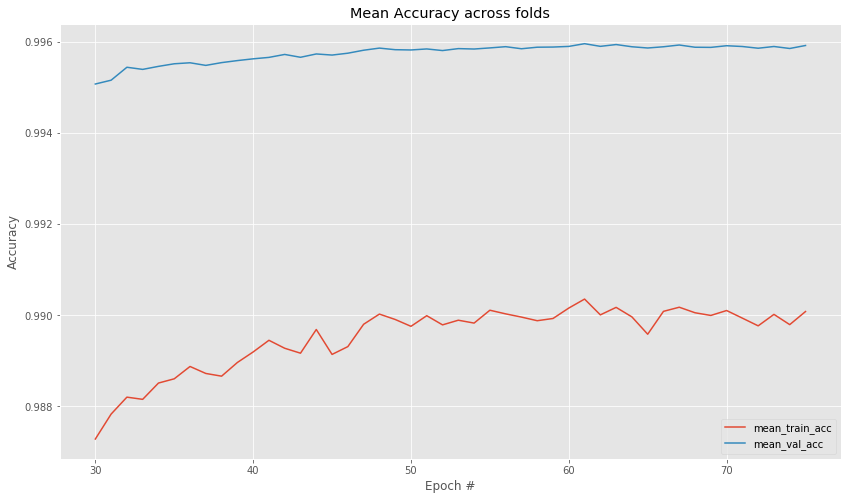

In [17]:
plt.figure(figsize=(14,8))
plt.plot(np.arange(lbound, ubound), df_cv_per_epoch_val_acc["mean_train_acc"][lbound-1:], label="mean_train_acc")
plt.plot(np.arange(lbound, ubound), df_cv_per_epoch_val_acc["mean_val_acc"][lbound-1:], label="mean_val_acc")
plt.title("Mean Accuracy across folds")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.show()

#### Your <span style="color:green">upvote</span> encourages people to share their code.

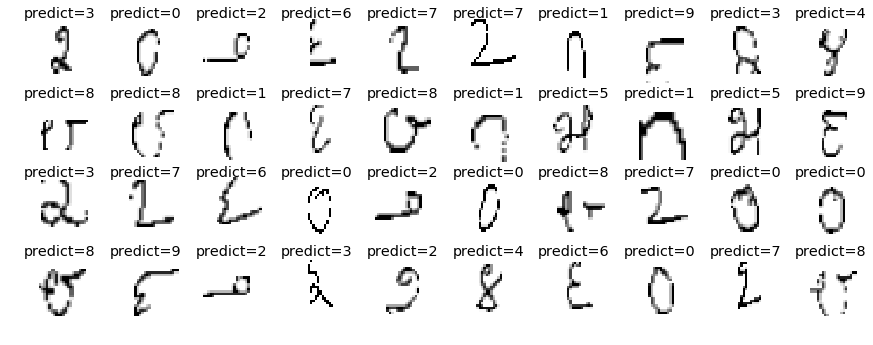

In [18]:
# PREVIEW PREDICTIONS
plt.figure(figsize=(15,6))
for i in range(40):  
    plt.subplot(4, 10, i+1)
    plt.imshow(X_test[i].reshape((28,28)),cmap=plt.cm.binary)
    plt.title("predict=%d" % results[i],y=0.9)
    plt.axis('off')
plt.subplots_adjust(wspace=0.3, hspace=-0.1)
plt.show()

#### Holdout Validation

In the original MNIST competition validation scores achieved whilst training the model were in line with the accuracy scores on the test set on the public leaderboard. In this competition to date they have not been. In this kernel validation accuracy has been around 0.997, but the leaderboard scores for has been around 0.987. At the time this notebook is being prepared near the end of the competition the highest score on the PLB is 0.9918.

Here, we use a holdout set to get a different perspective on validation accuracy. Fortunately the competition organisers have provided the Dig-MNIST dataset for validation. The competition notes state that accuracy on this holdout set has been reported to be much lower than on the test set. This is because the images were scanned in a different way. So we will keep that in mind when we interpret the resulting accuracy.

In [19]:
if Run_Holdout_Validation=="Y":
    holdout_preds = holdout_preds / K
    #format prediction
    results_holdout = np.argmax(holdout_preds,axis = 1)
    results_holdout = pd.Series(results_holdout,name="label") 

    holdout_accuracy = accuracy_score(y_holdout, results_holdout)
    print( " Holdout Accuracy = %3.5f"% (holdout_accuracy))

 Holdout Accuracy = 0.91338


### Where were the errors on the holdout set?

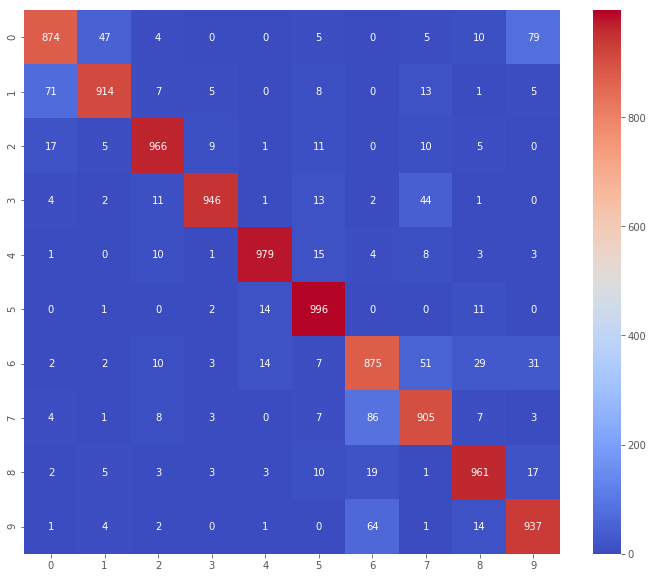

In [20]:
# build confusion matrix
conf = confusion_matrix(y_holdout, results_holdout)
conf = pd.DataFrame(conf, index=range(0,10), columns=range(0,10))

# plot the confusion matrix
plt.figure(figsize=(12,10))
sns.heatmap(conf, cmap="coolwarm", annot=True , fmt="d");

#### Summary

If the model ran then a summary of the model architecture will be shown. Otherwise a warning will show that the model didn't run.

In [21]:
if Run_Kaggle_Pred=="Y" or Run_CV=="Y":
    print(nnet_model.summary())
else:
    print("Select Cross-Validation Run, Kaggle Prediction, or both.")

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 28, 28, 64)        1664      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 14, 14, 128)       204928    
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 7, 7, 256)        

#### Blended Validation

In the previous run of this kernel we got a good approximation to the accuracy on the test set (public leaderboard) by taking a weighted average of the cross-validation and holdout validation values. The weights to this are overfit to values I have seen in previous runs of this kernel. I am not sure how well this will generalise either to later attempts on the public leaderboard let alone to the private leaderboard. Still it may be an improvement on the cross-validation accuracy which seems to have approached a frontier. What validation methods have you tried?

In [22]:
cv_weight = 7
holdout_weight = 1

blended_validation_accuracy = ((cv_weight * oof_accuracy) + (holdout_weight * holdout_accuracy)) / (cv_weight + holdout_weight)
print( "Blended Validation Accuracy = %3.5f"% (blended_validation_accuracy))

Blended Validation Accuracy = 0.98691


This value should not be taken as an accurate guide to the public leaderboard score or to the final private leaderboard accuracy. It is just one attempt to find a reliable validation approach. Finding a good validation approach is an important part of Machine Learning.

### Comments on Accuracy

Accuracy on the holdout set is lower. This could be due to overfitting to the training & validation data. However we know these images were captured in a different way. This could increase the complexity of getting high accuracy predictions on this holdout set. This situation might benefit from more complex CNN's than were required for the original MNIST.

## Further comments after the competition ended

The blended accuracy approach above did a reasonable job on this dataset of estimating the final result. That isn't surprising since it was mostly weighted to the cv score! On version 21 of this kernel, the blended validation score was 0.9872, the public score was 0.9876, and the private leaderboard score was 0.9886. 

### Credits

A lot of the ideas in the kernel came from working on the original MNIST competition. There are many useful kernels there that could be of interest. However, this competition is a unique challenge in itself and directly applying a solution from the other competition does not appear to be the optimal solution. 
* In this competition the [notebook](https://www.kaggle.com/jinbao/kannada-mnist-baseline/notebook?scriptVersionId=21092956) by [Jinbao](https://www.kaggle.com/jinbao) was helpful in a few different ways. 
* Also this [notebook](https://www.kaggle.com/ankur1401/kannada-digit-recognizer) by [Ankur](https://www.kaggle.com/ankur1401).
* This [notebook by Ronald](https://www.kaggle.com/bustam/cnn-in-keras-for-kannada-digits) was the single most helpful as it provided a slight improvement on other similar CNN architectures.
* This [notebook](https://www.kaggle.com/ilyamich/kannada-mnist-choosing-the-right-optimizer) was also useful in reminding me of the value of a confusion matrix.
* This [notebook](https://www.kaggle.com/arthurtok/interactive-intro-to-dimensionality-reduction) from the original MNIST competition has some fascinating visualisations.

#### Please <span style="color:blue">Upvote</span> if you learned something new or found this interesting.

In [23]:
print(('Run Completed: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now())))

Run Completed: 2020-01-03 02:34:04
